Going to do the same as salmon_* notebooks, but now we're going to use Guassian Process to characterise the parameters:

In [102]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

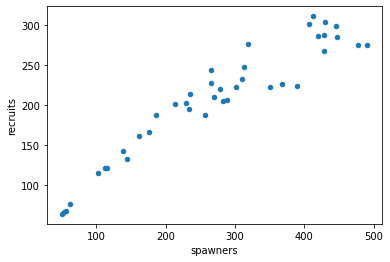

In [103]:
data = pd.read_table('../data/salmon.txt', sep='\s+')
data.plot.scatter(x='spawners', y='recruits');

Simple GP regression:
$$ \nu, \rho \sim \text{HalfCauchy}(5)$$
$$ \kappa(x,x') = \nu \exp \left( \frac{-(x-x')^2}{2 \rho^2} \right) $$

In [104]:
x, y = data[['spawners', 'recruits']].values.T

In [105]:
with pm.Model() as gp_salmon_model:

    # Length scale (cauchy allows for extream values).
    rho = pm.HalfCauchy('ρ', 5)
    nu = pm.HalfCauchy('η', 5)
    
    # Linaer fit
    M = pm.gp.mean.Linear(coeffs=(data.recruits/data.spawners).mean())

    # nu * exp(- (x - x')^2 / (2 * rho^2))
    K = (nu * nu) * pm.gp.cov.ExpQuad(1, rho) 
    
    sigma = pm.HalfNormal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=data.spawners.values.reshape(-1,1), y=data.recruits.values, noise=sigma)

In [106]:
with gp_salmon_model:
    gp_trace = pm.sample(1000, tune=2000, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ρ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 43 seconds.
The number of effective samples is smaller than 25% for some parameters.


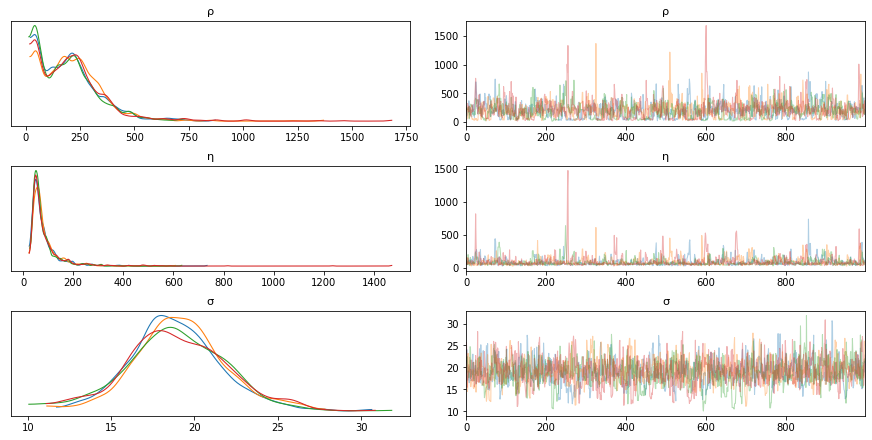

In [107]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [108]:
X_pred = np.linspace(0, 500, 100)

with gp_salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred.reshape(-1, 1))
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, vars=[salmon_pred], samples=100)

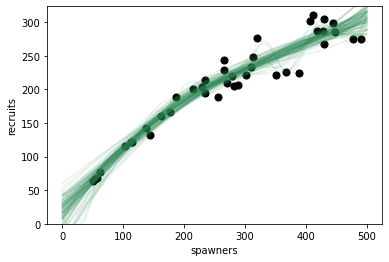

In [110]:
ax = data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_salmon_samples['salmon_pred']:
    ax.plot(X_pred, x, alpha=0.1, color='seagreen');

In [111]:
with gp_salmon_model:
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, vars=[salmon_pred], samples=100, random_seed=42)

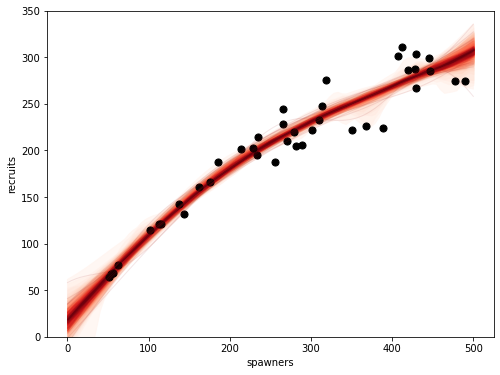

In [113]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred'], X_pred)
data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

In [114]:
with gp_salmon_model:
    salmon_pred_noise = recruit_gp.conditional("salmon_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, vars=[salmon_pred_noise], samples=500, random_seed=42)

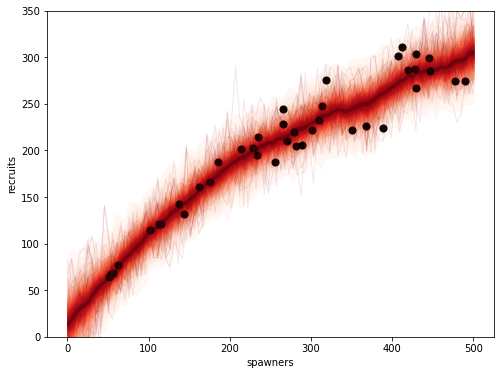

In [116]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred_noise'], X_pred)
data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);